In [1]:
# import and clean pokemon name data

import csv

names = []

with open('Pokemon.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skips header row
    for row in reader:
        if len(row) > 1:
            names.append(row[1])

In [2]:
names[:10]

['Bulbasaur',
 'Ivysaur',
 'Venusaur',
 'VenusaurMega Venusaur',
 'Charmander',
 'Charmeleon',
 'Charizard',
 'CharizardMega Charizard X',
 'CharizardMega Charizard Y',
 'Squirtle']

In [3]:
b = {}

for n in names:
    chs = ['<S>'] + list(n) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0 ) + 1 # adds up bigrams and counts how often they occur

In [4]:
sorted(b.items(), key=lambda kv: -kv[1])

[(('e', '<E>'), 149),
 (('a', 'r'), 112),
 (('<S>', 'S'), 112),
 (('a', 'n'), 92),
 (('o', 'r'), 82),
 (('o', 'n'), 78),
 (('i', 'n'), 75),
 (('n', '<E>'), 74),
 (('r', 'o'), 72),
 (('M', 'e'), 70),
 (('l', 'e'), 69),
 (('e', 'r'), 68),
 (('r', 'a'), 68),
 (('r', '<E>'), 67),
 (('g', 'a'), 67),
 (('<S>', 'M'), 67),
 (('a', '<E>'), 63),
 (('r', 'i'), 60),
 (('e', 'g'), 58),
 (('<S>', 'C'), 58),
 (('<S>', 'G'), 58),
 (('l', 'a'), 54),
 (('<S>', 'P'), 53),
 (('e', 'l'), 52),
 (('t', '<E>'), 52),
 (('s', '<E>'), 52),
 (('a', ' '), 51),
 (('u', 'r'), 48),
 (('i', 'l'), 48),
 (('l', 'i'), 47),
 (('t', 'a'), 46),
 (('<S>', 'D'), 46),
 (('<S>', 'B'), 43),
 (('a', 's'), 42),
 (('a', 't'), 42),
 (('<S>', 'A'), 42),
 (('m', 'e'), 41),
 (('i', 't'), 41),
 (('y', '<E>'), 40),
 (('d', 'o'), 40),
 (('a', 'l'), 40),
 (('o', 'o'), 40),
 (('<S>', 'T'), 40),
 (('t', 'o'), 39),
 (('r', 'e'), 39),
 (('o', 't'), 39),
 (('o', '<E>'), 39),
 (('<S>', 'L'), 39),
 (('e', 'n'), 38),
 (('n', 'e'), 38),
 (('l', 'o'

In [5]:
# finding # of unique chars so we can set our Tensor dim. later

all_chars = set(''.join(names))

num_unique_chars = len(all_chars)

print(num_unique_chars)
print(all_chars)

63
{'l', 'p', 'k', 'w', 'W', 'N', 'u', 'S', 'L', 'Y', 'J', 'E', 'm', 'F', 'Q', 'Z', 'a', 'v', 'V', 'K', 'X', 'y', 's', 't', 'h', 'R', 'j', 'o', 'U', 'D', '0', 'n', 'é', 'I', '5', 'G', '-', '.', '%', 'O', 'b', '2', 'g', 'q', '♀', '♂', 'C', 'x', 'z', 'M', ' ', 'i', "'", 'd', 'f', 'r', 'H', 'A', 'B', 'c', 'e', 'T', 'P'}


In [6]:
import os
import numpy as np
import time
from tinygrad import Tensor

os.environ['GPU'] = '1'

In [7]:
N = Tensor.zeros(64,64, dtype='int32').contiguous()

In [8]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['|'] = 0
itos = {i:s for s,i in stoi.items()}

In [9]:
# doing calcs in numpy for speed...

N = np.zeros((64, 64), dtype=np.int32)

for n in names:
    chs = ['|'] + list(n) + ['|']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

#N_tiny = Tensor(N, dtype='int32')
#print(N_tiny.numpy())

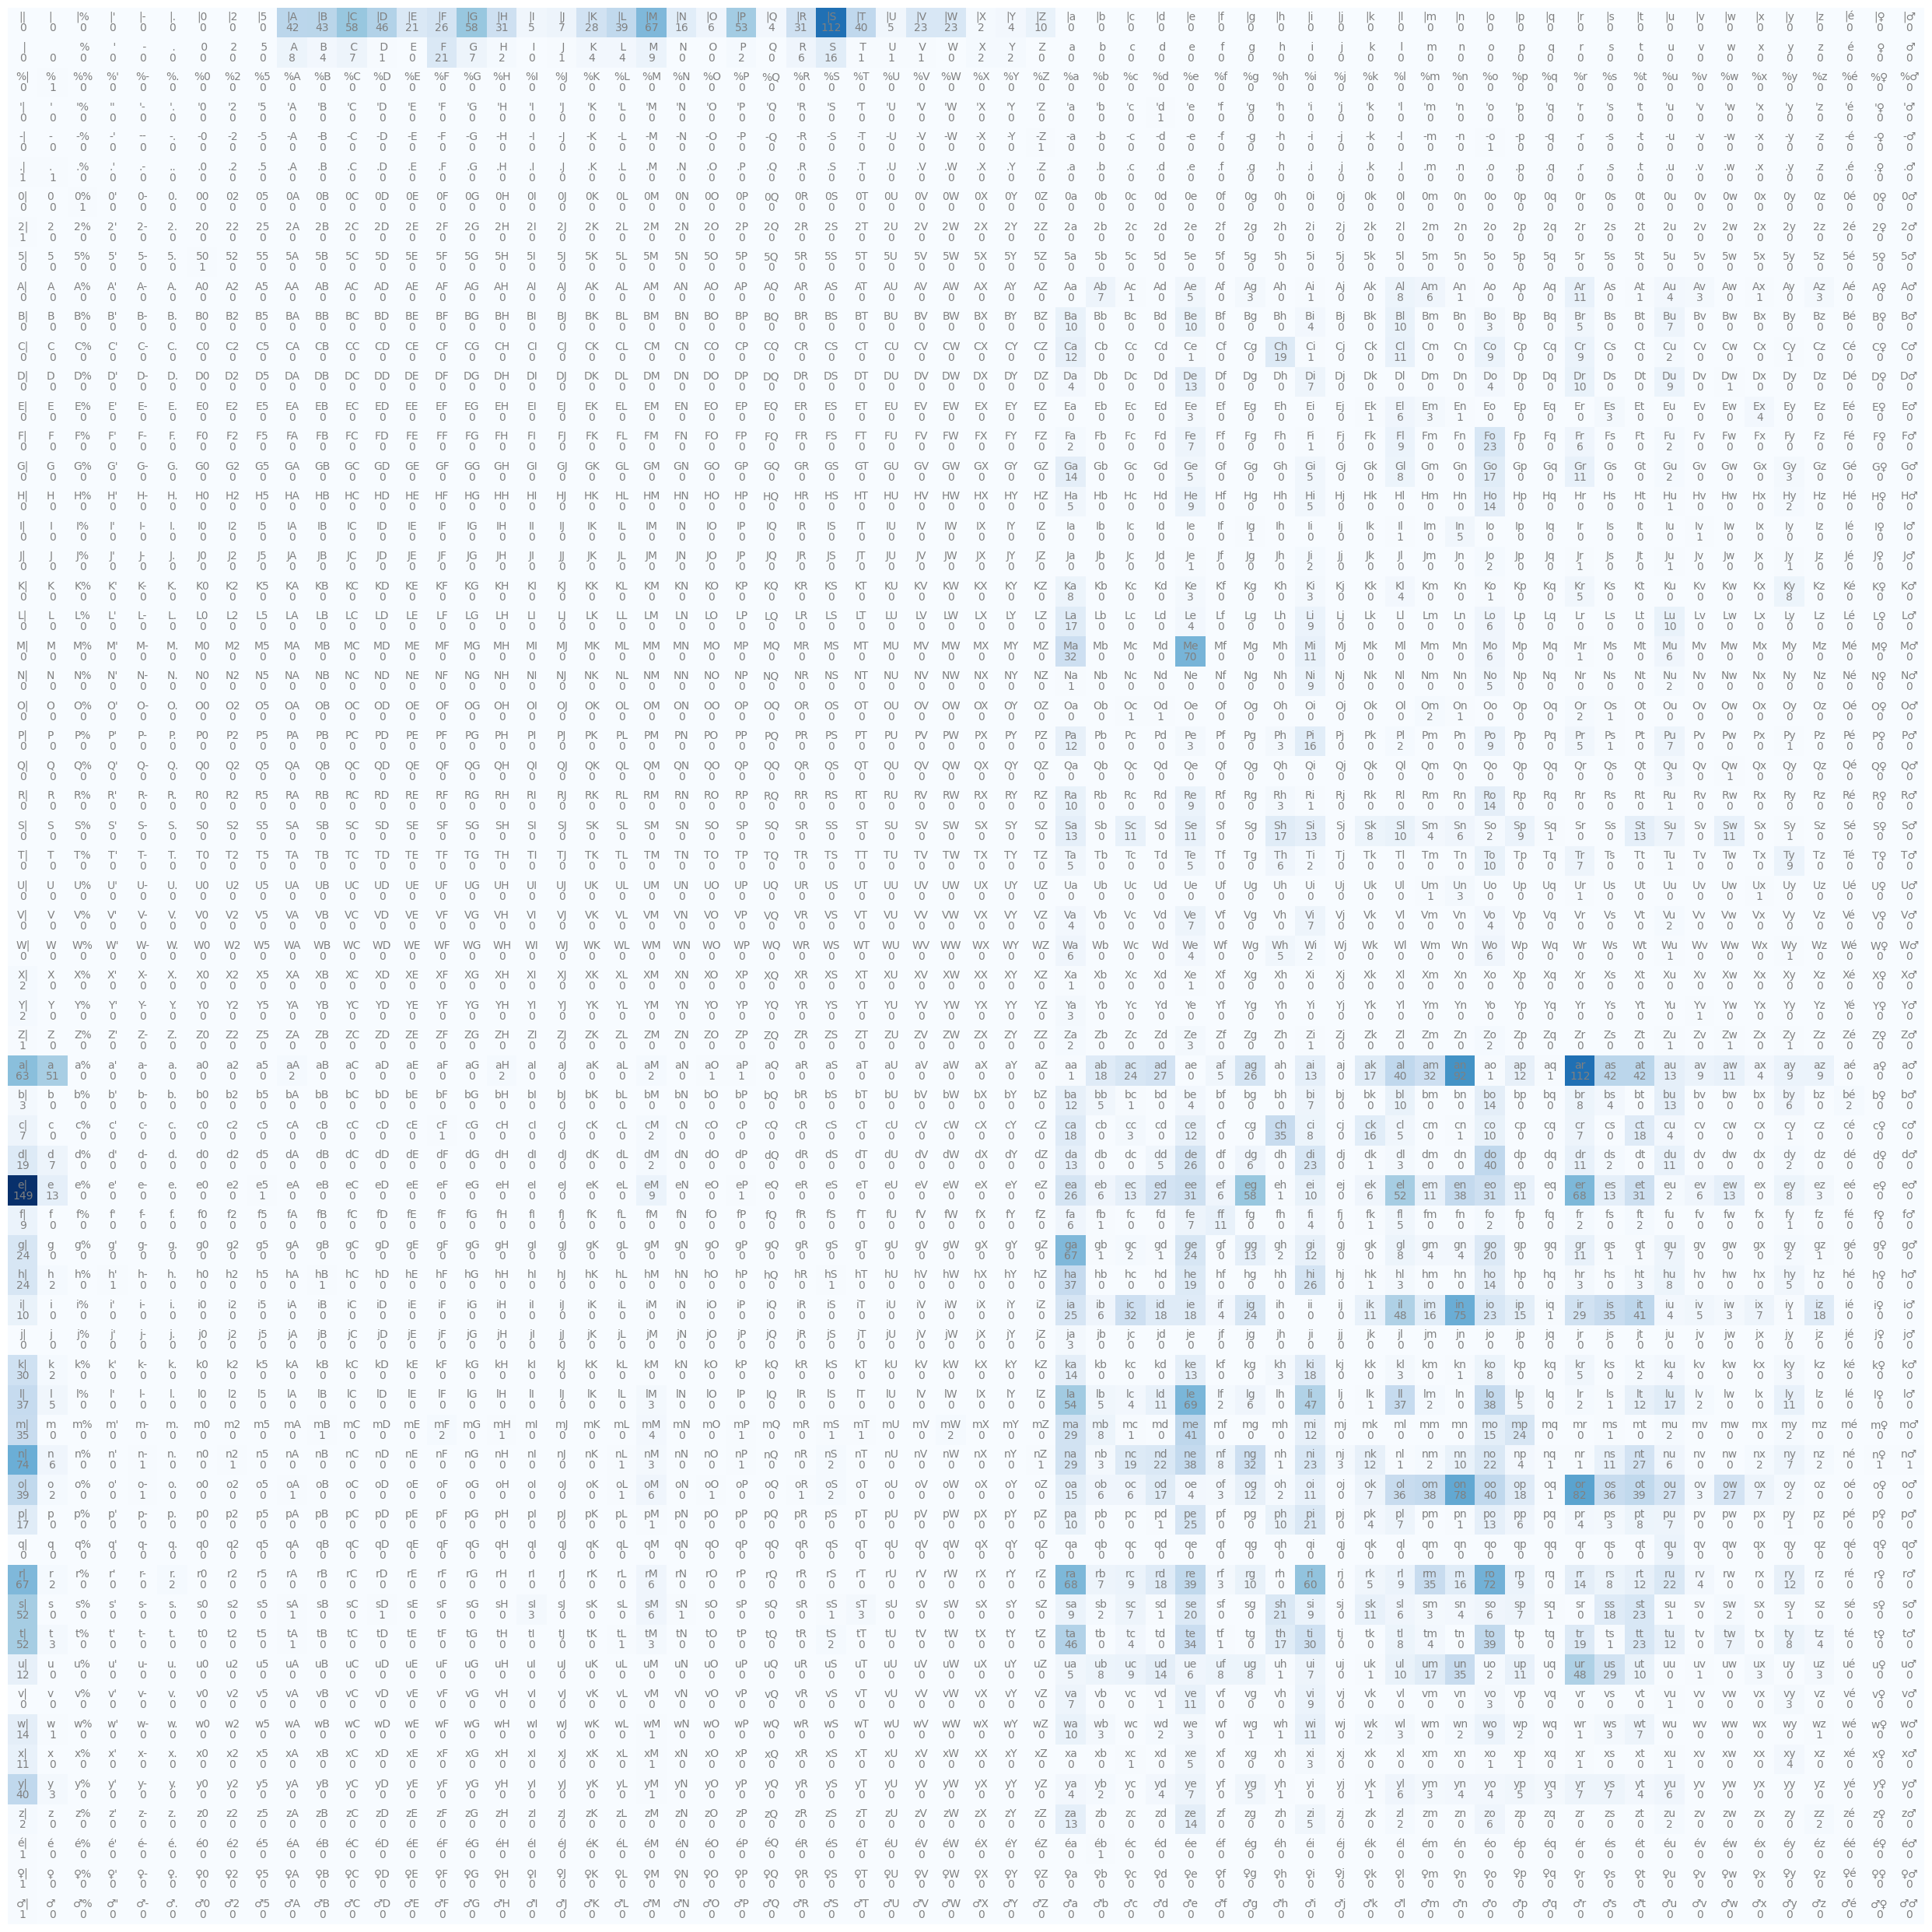

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(32,32))
plt.imshow(N, cmap='Blues')
for i in range(64):
    for j in range(64):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [11]:
p = N[0].astype(np.float64)
p = p / p.sum()
print(p)

[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.0525  0.05375 0.0725  0.0575  0.02625 0.0325  0.0725  0.03875 0.00625
 0.00875 0.035   0.04875 0.08375 0.02    0.0075  0.06625 0.005   0.03875
 0.14    0.05    0.00625 0.02875 0.02875 0.0025  0.005   0.0125  0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]


In [12]:
ix = np.random.multinomial(1, p).argmax()
itos[ix]

'A'

In [14]:
# smoothing model
P = (N+0.001).astype(np.float64)
P /= P.sum(1, keepdims=True)

In [59]:
for i in range(5):

    ix = 0
    out = []
    while True:
        p = P[ix]
        #p = N[ix].astype(np.float64)
        #p = p / p.sum()
        ix = np.random.multinomial(1, p).argmax()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

Abile Un Grvefiperogre|
X|
Plina Abe Pie|
Wht|
Sinturru|


In [ ]:
# Lamineamalt|

In [16]:
log_likelihood = 0.0
count = 0.0
for n in names:
    chs = ['|'] + list(n) + ['|']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = np.log(prob)
        log_likelihood += logprob
        count += 1.0
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/count}')

log_likelihood=np.float64(-19996.625111552654)
nll=np.float64(19996.625111552654)
2.5398990361428493


In [ ]:
# ^^^^ is bigram
# vvvv is makemore

In [17]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for n in names[:1]:
    chs = ['|'] + list(n) + ['|']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = Tensor(xs)
ys = Tensor(ys)

| B
B u
u l
l b
b a
a s
s a
a u
u r
r |


In [18]:
xs.numpy()

array([ 0, 10, 55, 46, 36, 35, 53, 35, 55, 52], dtype=int32)

In [19]:
ys.numpy()

array([10, 55, 46, 36, 35, 53, 35, 55, 52,  0], dtype=int32)

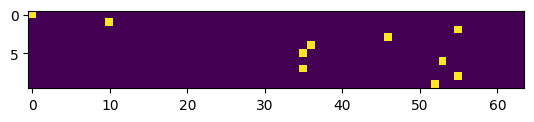

In [20]:
xenc = Tensor.one_hot(xs, num_classes=64).float()
plt.imshow(xenc.numpy())

In [21]:
W = Tensor.randn(64,64)

logits = xenc.matmul(W) # log counts
counts = logits.exp() # eqv.
probs = counts / counts.sum(1, keepdim=True)
probs.numpy()

array([[0.05122672, 0.00200948, 0.0071949 , 0.00209744, 0.0094961 ,
        0.00394414, 0.00582658, 0.0803296 , 0.00127283, 0.00463782,
        0.00390806, 0.00905721, 0.01557405, 0.00203678, 0.00166353,
        0.01421857, 0.00836237, 0.00882933, 0.0090007 , 0.04112262,
        0.00785091, 0.12073734, 0.00834465, 0.00393252, 0.01368023,
        0.00574103, 0.02644279, 0.0189698 , 0.00301986, 0.01242474,
        0.00753546, 0.05161833, 0.00189786, 0.01043368, 0.02256258,
        0.00401066, 0.00150638, 0.01528898, 0.00943945, 0.06228155,
        0.00327204, 0.00668866, 0.06653732, 0.00130443, 0.00907043,
        0.00687804, 0.0026902 , 0.02099769, 0.01963767, 0.04554509,
        0.00390842, 0.01618659, 0.00522094, 0.0155869 , 0.00360978,
        0.01099842, 0.00341175, 0.0035033 , 0.00400922, 0.00440509,
        0.02788606, 0.00575176, 0.02018783, 0.00318472],
       [0.01707227, 0.00172559, 0.0213745 , 0.01470452, 0.02739607,
        0.01638903, 0.00896275, 0.03032657, 0.00535289, 0.0

In [22]:
# rndm init for 64 neuronal weights, each neuron receives 64 inputs
W = Tensor.randn(64,64, requires_grad=True)

In [23]:
#foward pass

xenc = Tensor.one_hot(xs, num_classes=64).float()
logits = xenc.matmul(W) # log counts
counts = logits.exp() # eqv.
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[Tensor.arange(10), ys].log().mean()

In [24]:
#backward pass

W.grad = W.zeros_like()
loss.backward()

<Tensor <UOp GPU () float (<Ops.MUL: 49>, None)> on GPU with grad UOp(Ops.CONST, dtypes.float, arg=1.0, src=(
  UOp(Ops.VIEW, dtypes.void, arg=ShapeTracker(views=(View(shape=(), strides=(), offset=0, mask=None, contiguous=True),)), src=(
    UOp(Ops.DEVICE, dtypes.void, arg='GPU', src=()),)),))>

In [25]:
loss.numpy()

array(5.236034, dtype=float32)

In [26]:
# update

W.replace(W.add(-0.1 * W.grad))

<Tensor <UOp GPU (64, 64) float (<Ops.ADD: 48>, None)> on GPU with grad UOp(Ops.ADD, dtypes.float, arg=None, src=(
  UOp(Ops.EXPAND, dtypes.float, arg=(64, 64), src=(
    UOp(Ops.RESHAPE, dtypes.float, arg=(1, 1), src=(
      UOp(Ops.CONST, dtypes.float, arg=0.0, src=(
        x3:=UOp(Ops.VIEW, dtypes.void, arg=ShapeTracker(views=(View(shape=(), strides=(), offset=0, mask=None, contiguous=True),)), src=(
          x4:=UOp(Ops.DEVICE, dtypes.void, arg='GPU', src=()),)),)),)),)),
  UOp(Ops.RESHAPE, dtypes.float, arg=(64, 64), src=(
    UOp(Ops.PERMUTE, dtypes.float, arg=(0, 2, 1), src=(
      UOp(Ops.CAST, dtypes.float, arg=None, src=(
        UOp(Ops.REDUCE_AXIS, dtypes.float, arg=(Ops.ADD, (0,)), src=(
          UOp(Ops.CAST, dtypes.float, arg=None, src=(
            UOp(Ops.MUL, dtypes.float, arg=None, src=(
              UOp(Ops.VIEW, dtypes.float, arg=ShapeTracker(views=(View(shape=(10, 64, 64), strides=(64, 0, 1), offset=0, mask=None, contiguous=False),)), src=(
                UOp

In [27]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for n in names:
    chs = ['|'] + list(n) + ['|']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = Tensor(xs)
ys = Tensor(ys)
num = xs.numel()
print('# of examples: ', num)

# rndm init for 64 neuronal weights, each neuron receives 64 inputs
W = Tensor.randn(64,64, requires_grad=True)

# of examples:  7873


In [37]:
# grad desc.

start = time.time()

for k in range(50):
    
    #foward pass
    xenc = Tensor.one_hot(xs, num_classes=64).float()
    logits = xenc.matmul(W) # log counts
    counts = logits.exp() # eqv.
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[Tensor.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    

    #backward pass
    W.grad = W.zeros_like()
    loss.backward()

    print(loss.item())

    # update
    W.replace(W.add(-50 * W.grad))

end = time.time()
print('Time taken: ', end - start)

2.598959445953369
2.5988996028900146
2.598846435546875
2.598788022994995
2.5987298488616943
2.59867262840271
2.5986082553863525
2.5985467433929443
2.5984833240509033
2.598416566848755
2.5983636379241943
2.598304510116577
2.5982489585876465
2.59818959236145
2.5981340408325195
2.5980751514434814
2.5980188846588135
2.597966432571411
2.5979087352752686
2.597853899002075
2.5977962017059326
2.5977394580841064
2.597689390182495
2.597637891769409
2.5975894927978516
2.5975377559661865
2.59748911857605
2.597440004348755
2.5973873138427734
2.5973381996154785
2.597289562225342
2.5972352027893066
2.5971755981445312
2.5971293449401855
2.5970780849456787
2.5970258712768555
2.5969769954681396
2.5969247817993164
2.596877336502075
2.5968337059020996
2.596782922744751
2.5967354774475098
2.5966837406158447
2.5966293811798096
2.596581220626831
2.596536874771118
2.5964715480804443
2.5964221954345703
2.5963761806488037
2.596327304840088
Time taken:  46.718557834625244


In [1]:
#sampling from neural net

for i in range(5):

    ix = 0
    out = []
    while True:

        xenc = Tensor.one_hot(Tensor([ix], dtype='int'), num_classes=64).float()
        logits = xenc.matmul(W) # log counts
        counts = logits.exp() # eqv.

        p = (counts / counts.sum(1, keepdim=True)).numpy()
        ix = np.random.multinomial(1, p[0]).argmax()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

NameError: name 'Tensor' is not defined